# Introduction
I come from Taiwan and I was always thinking about how to efficiently do the web scrapying. I found that python scrapy is very easy to learn and use for scrapying. Therefore, I decide to use this tutorial to introduce how we use the scrapy and how we could use the result of scrapy to analyze the result from scrapy. The target website is the biggest forum in Taiwan named PTT whcih contains hundreds of discussion areas. I will try to scrape one discussion area which mainly focuses on sharing the image of beauties and handsome guys


# Tutorial Content
* [Installing the libraries](#Installing-the-libraries)
* [Framework of scrapy](#Framework-of-scrapy)
* [Setting the environment](#Setting-the-environment)
* [Writer our spider](#Write-our-spider)
* [Analyze the data](#Analyze-the-data)

## Installing the libraries

Before getting started, you'll need to install the scrapy which we will use, we can use pip to install this library
```
pip install scrapy
```

Alteratively you can use Conda:
```
conda install -c conda-forge scrapy
```

Note: If you use Windows platform, please download the package depends on your Windows 32/64 platform
```
https://sourceforge.net/projects/pywin32/
```
You may need other dependency package:
```
lxml-3.6.4-cp27-cp27m-win_amd64.whl

```

## Framework of scrapy
The data process of scrapy is handled by scrapy engine
-----------------------------------------------------
1. Engine turns on the domain name and the spider will handle it and let the spider retrieve the first URL
2. Engine gets the first url from spider, and request the scheduler to schelue this task
3. Engine get the required page from the scheduler
4. Scheduler returns the next url to the engine, and the engine send this url to the downloader by download middleware
5. When the downloader finished the web download, the "responses" is passed to the scrapy engine through downloader
   middleware
6. The engine receives the response from the downloader and pass to the spider via spider middleware
7. The spider handles the responses and return the scraped items. Then, send the new request to engine
8. Engine sends new request to the scheduler
9. The system repeats the operation from step 2 until there is no request in the scheduler

** Please reference the following photo when reviewing the above steps **
![Alt text](https://github.com/yihnanc/photo/raw/master/scrapy.png "Scrapy Process")

Function of each part in scrapy
--------------------------------
* Scrapy Engine: Trigger event and handle the data stream of the whole system
* Spider Middleware: It's between Spider and Scrapy Engine, whcih is used to handle the input and output between spider and scrapy engine
* Scheduler Middleware: It's between scrapy engine and the scheduler, which is used to handle the request and response from/to scrapy engine
* Scheduler: It's used to receive the request from scrapy engine, and put the request into queue, then, return when the engine asks for url
* Downloader middlewares: It's between scrapy engine and the downloader, which is used to handle the request/response between scrapy engine and the downloader
* Downloader: It's used to download the content of web and pass to the spider
* Spider: It's the most important part of the spider, which is used to let users customize the parse rules

## Setting the environment

Before going through my example to show the functionality of scrapy, we need to set the environment first, since scrapy need the support from shell, which means if we need to execute some scrapy command on terminal for executing the web crawling. Therefore, we need to use some library to support our code execution

### Use IPython
IPython is a interactive python shell which supports more powerful edit and interaction, which is more convenient than the python shell

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import platform

### Use Crawler Runner
In the terminal, we usually need to type in "scrapy crawl xxx" to run the web crawling, but we can't do this in jupter notebook. Therefore, we need to use "CrawlerRunner" to help us achieve our target, the API usage will be listed later

In [2]:
import scrapy
from twisted.internet import reactor
from scrapy.crawler import CrawlerRunner
from scrapy.utils.log import configure_logging

### Run my example
Before we introduce the how we write the web scrapying program by scrapy, I will give my complete code first and explain different part of function in detail

### Output format of our web crawling
For storing the scrapying output, we need to decide how we store the data, in my example, I will store the desired data in json format, thereforre, I define a class which contains the different field for storing. Item isa copy of dict API and Field is just an alias to the built-in dict class which doesn't prvide any extra functionality. At the following output format.

In [3]:

class PostItem(scrapy.Item):
    title = scrapy.Field()
    # The id of this poster
    id = scrapy.Field()
    # The nickname of this poster
    nickname = scrapy.Field()
    date = scrapy.Field()
    # The comment for this post
    comments = scrapy.Field()
    # Total number of likes
    score = scrapy.Field()
    # The url of this post
    url = scrapy.Field()
    # images of this post
    img = scrapy.Field()
    content = scrapy.Field()

In [4]:
import scrapy

import logging

from datetime import datetime

import html2text
import scrapy

from scrapy.http import FormRequest

class PTTSpider(scrapy.Spider):
    name = 'ptt'
    start_urls = ('https://www.ptt.cc/bbs/Beauty/index.html', )
    
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT':'json',                                 
        'FEED_URI': 'beauty.json'                 
    }

    MAX_RETRY = 1
    retries = 0

    MAX_PAGES = 10
    pages = 0

    MAX_COMMENT = 100

    def parse(self, response):
        # div, which owns class names "over18-notice"
        if len(response.xpath('//div[@class="over18-notice"]')) > 0:
            if self.retries < PTTSpider.MAX_RETRY:
                self.retries += 1
                logging.warning('retry {} times...'.format(self.retries))
                # Give response back to ptt
                yield FormRequest.from_response(response,
                                                formdata={'yes': 'yes'},
                                                callback=self.parse)
            else:
                logging.warning('you cannot pass')

        else:
            self.pages += 1
            # print("rrrrrrrrrrr",response.text)
            # response xpath return selector list
            for href in response.xpath('//div[@class="r-ent"]//div[@class="title"]/a/@href'):
                # reconstruct url
                url = response.urljoin(href.extract())
                print(href.extract(), url)
                yield scrapy.Request(url, callback=self.parse_post, meta = {'comment' : PTTSpider.MAX_COMMENT})

            if self.pages < PTTSpider.MAX_PAGES:
                # heprlink contains thte text names "上頁"
                next_page = response.xpath(
                    '//div[@id="action-bar-container"]//a[contains(text(), "上頁")]/@href')
                if next_page:
                    url = response.urljoin(next_page[0].extract())
                    logging.warning('follow {}'.format(url))
                    yield scrapy.Request(url, self.parse)
                else:
                    logging.warning('no next page')
            else:
                logging.warning('max pages reached')


    def parse_post(self, response):
        # print(response.text)
        item = PostItem()
        title = response.xpath('//meta[@property="og:title"]/@content')[0].extract()
        max = response.meta.get('comment')
        # print("max comment count:",max)
        # Means not the post of beauty
        # if "公告" in title:
            # yield item
            # return

        item['title'] = title
        author = response.xpath('//span[text()="作者"]/following-sibling::span[1]/text()')[0].extract().split(' ')
        item['id'] = author[0]
        if (len(author) > 1):
            item['nickname'] = author[1]

        date = response.xpath('//span[text()="時間"]/following-sibling::span[1]/text()')[0].extract()
        item['date'] = datetime.strptime(date, '%a %b %d %H:%M:%S %Y')
        # image of beauty
        graphs = response.xpath('//div[@id="main-content"]/a/text()')
        lst = []

        for graph in graphs:
            lst.append(graph.extract())

        item['img'] = lst

        converter = html2text.HTML2Text()
        converter.ignore_links = True
        item['content'] = converter.handle(response.xpath('//div[@id="main-content"]')[ 0].extract())
        item['url'] = response.url

        comments = []
        total_score = 0
        for comment in response.xpath('//div[@class="push"]'):
            push_tag = comment.css('span.push-tag::text')[0].extract()
            push_user = comment.css('span.push-userid::text')[0].extract()
            push_content = comment.css('span.push-content::text')[0].extract()

            score = 0

            if '推' in push_tag:
                score = 1
            elif '噓' in push_tag:
                score = -1

            total_score += score

            comments.append({'user': push_user,
                             'content': push_content,
                             'score': score})

        item['score'] = total_score
        item['comments'] = comments

        yield item


Before I execute my spider, I need to point out some situation that I have never seen in terminal but actually happend when I used jupter notebook
1. Once you execute the "reactor.run()" once, you can't execute the second time, or it will show the below error:
```
        <Deferred at 0x116aab860>
        ---------------------------------------------------------------------------
        ReactorNotRestartable                     Traceback (most recent call last)
        <ipython-input-10-b30de2845b89> in <module>()
              6 # Stop after executing
              7 d.addBoth(lambda _: reactor.stop())
        ----> 8 reactor.run() # the script will block here until the crawling is finished

        ~/anaconda3/lib/python3.6/site-packages/twisted/internet/base.py in run(self, installSignalHandlers)
           1240 
           1241     def run(self, installSignalHandlers=True):
        -> 1242         self.startRunning(installSignalHandlers=installSignalHandlers)
           1243         self.mainLoop()
           1244 

        ~/anaconda3/lib/python3.6/site-packages/twisted/internet/base.py in startRunning(self, installSignalHandlers)
           1220         """
           1221         self._installSignalHandlers = installSignalHandlers
        -> 1222         ReactorBase.startRunning(self)
           1223 
           1224 

        ~/anaconda3/lib/python3.6/site-packages/twisted/internet/base.py in startRunning(self)
            728             raise error.ReactorAlreadyRunning()
            729         if self._startedBefore:
        --> 730             raise error.ReactorNotRestartable()
            731         self._started = True
            732         self._stopped = False

        ReactorNotRestartable: 

```
> I try to google online and use someway to fix this issue, but it still not works, therefore, if you want to execute 
> my spider code, please restart the notebook, that's the only way I can do now
2. I use the following code to avoid my spider retrieve some unnecessary data, however, it will cause json parse error
> when in the analysis part at jupyter but can run well on my terminal
```
        # Means not the post of beauty
        # if "公告" in title:
            # yield item
            # return
```


### Executing the example code
The above code is the complete code for scrapying the posts of beauties, I will explain each part later, but how could we execute this scrapying code on jupyter instead of typing commands on terminal? We need to use "CrawlerRunner" to help us achieve this

In [5]:

configure_logging({'LOG_FORMAT': '%(levelname)s: %(message)s'})
runner = CrawlerRunner()

d = runner.crawl(PTTSpider)
# Stop after executing
d.addBoth(lambda _: reactor.stop())
reactor.run() # the script will block here until the crawling is finished

INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'beauty.json', 'LOG_LEVEL': 30}


2018-03-30 13:57:53 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2433.html


/bbs/Beauty/M.1522394375.A.C92.html https://www.ptt.cc/bbs/Beauty/M.1522394375.A.C92.html
/bbs/Beauty/M.1522398712.A.1BB.html https://www.ptt.cc/bbs/Beauty/M.1522398712.A.1BB.html
/bbs/Beauty/M.1522403374.A.7D4.html https://www.ptt.cc/bbs/Beauty/M.1522403374.A.7D4.html
/bbs/Beauty/M.1522405808.A.6E8.html https://www.ptt.cc/bbs/Beauty/M.1522405808.A.6E8.html
/bbs/Beauty/M.1522405988.A.846.html https://www.ptt.cc/bbs/Beauty/M.1522405988.A.846.html
/bbs/Beauty/M.1522409638.A.708.html https://www.ptt.cc/bbs/Beauty/M.1522409638.A.708.html
/bbs/Beauty/M.1522416486.A.BEF.html https://www.ptt.cc/bbs/Beauty/M.1522416486.A.BEF.html
/bbs/Beauty/M.1522416874.A.DFE.html https://www.ptt.cc/bbs/Beauty/M.1522416874.A.DFE.html
/bbs/Beauty/M.1522418387.A.0E8.html https://www.ptt.cc/bbs/Beauty/M.1522418387.A.0E8.html
/bbs/Beauty/M.1522418451.A.660.html https://www.ptt.cc/bbs/Beauty/M.1522418451.A.660.html
/bbs/Beauty/M.1522420581.A.170.html https://www.ptt.cc/bbs/Beauty/M.1522420581.A.170.html
/bbs/Beaut

2018-03-30 13:57:54 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2432.html


/bbs/Beauty/M.1522314273.A.D52.html https://www.ptt.cc/bbs/Beauty/M.1522314273.A.D52.html
/bbs/Beauty/M.1522314352.A.45F.html https://www.ptt.cc/bbs/Beauty/M.1522314352.A.45F.html
/bbs/Beauty/M.1522314828.A.06B.html https://www.ptt.cc/bbs/Beauty/M.1522314828.A.06B.html
/bbs/Beauty/M.1522326485.A.A84.html https://www.ptt.cc/bbs/Beauty/M.1522326485.A.A84.html
/bbs/Beauty/M.1522328664.A.779.html https://www.ptt.cc/bbs/Beauty/M.1522328664.A.779.html
/bbs/Beauty/M.1522329493.A.F81.html https://www.ptt.cc/bbs/Beauty/M.1522329493.A.F81.html
/bbs/Beauty/M.1522338333.A.EBA.html https://www.ptt.cc/bbs/Beauty/M.1522338333.A.EBA.html
/bbs/Beauty/M.1522338910.A.150.html https://www.ptt.cc/bbs/Beauty/M.1522338910.A.150.html
/bbs/Beauty/M.1522345704.A.DC6.html https://www.ptt.cc/bbs/Beauty/M.1522345704.A.DC6.html
/bbs/Beauty/M.1522348755.A.5BA.html https://www.ptt.cc/bbs/Beauty/M.1522348755.A.5BA.html
/bbs/Beauty/M.1522367908.A.1F2.html https://www.ptt.cc/bbs/Beauty/M.1522367908.A.1F2.html
/bbs/Beaut

2018-03-30 13:57:57 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2431.html


/bbs/Beauty/M.1522247899.A.DBA.html https://www.ptt.cc/bbs/Beauty/M.1522247899.A.DBA.html
/bbs/Beauty/M.1522248235.A.956.html https://www.ptt.cc/bbs/Beauty/M.1522248235.A.956.html
/bbs/Beauty/M.1522250210.A.E75.html https://www.ptt.cc/bbs/Beauty/M.1522250210.A.E75.html
/bbs/Beauty/M.1522250840.A.EA2.html https://www.ptt.cc/bbs/Beauty/M.1522250840.A.EA2.html
/bbs/Beauty/M.1522259525.A.26C.html https://www.ptt.cc/bbs/Beauty/M.1522259525.A.26C.html
/bbs/Beauty/M.1522279922.A.06B.html https://www.ptt.cc/bbs/Beauty/M.1522279922.A.06B.html
/bbs/Beauty/M.1522281618.A.AC4.html https://www.ptt.cc/bbs/Beauty/M.1522281618.A.AC4.html
/bbs/Beauty/M.1522282925.A.7DE.html https://www.ptt.cc/bbs/Beauty/M.1522282925.A.7DE.html
/bbs/Beauty/M.1522289094.A.537.html https://www.ptt.cc/bbs/Beauty/M.1522289094.A.537.html
/bbs/Beauty/M.1522297332.A.4F4.html https://www.ptt.cc/bbs/Beauty/M.1522297332.A.4F4.html
/bbs/Beauty/M.1522298961.A.DD9.html https://www.ptt.cc/bbs/Beauty/M.1522298961.A.DD9.html
/bbs/Beaut

2018-03-30 13:57:59 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2430.html


/bbs/Beauty/M.1522164969.A.93A.html https://www.ptt.cc/bbs/Beauty/M.1522164969.A.93A.html
/bbs/Beauty/M.1522165424.A.786.html https://www.ptt.cc/bbs/Beauty/M.1522165424.A.786.html
/bbs/Beauty/M.1522166207.A.094.html https://www.ptt.cc/bbs/Beauty/M.1522166207.A.094.html
/bbs/Beauty/M.1522166956.A.328.html https://www.ptt.cc/bbs/Beauty/M.1522166956.A.328.html
/bbs/Beauty/M.1522192203.A.340.html https://www.ptt.cc/bbs/Beauty/M.1522192203.A.340.html
/bbs/Beauty/M.1522198439.A.273.html https://www.ptt.cc/bbs/Beauty/M.1522198439.A.273.html
/bbs/Beauty/M.1522211188.A.67D.html https://www.ptt.cc/bbs/Beauty/M.1522211188.A.67D.html
/bbs/Beauty/M.1522218693.A.93E.html https://www.ptt.cc/bbs/Beauty/M.1522218693.A.93E.html
/bbs/Beauty/M.1522235523.A.512.html https://www.ptt.cc/bbs/Beauty/M.1522235523.A.512.html
/bbs/Beauty/M.1522238912.A.3AE.html https://www.ptt.cc/bbs/Beauty/M.1522238912.A.3AE.html
/bbs/Beauty/M.1522242086.A.B28.html https://www.ptt.cc/bbs/Beauty/M.1522242086.A.B28.html
/bbs/Beaut

2018-03-30 13:57:59 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2429.html


/bbs/Beauty/M.1522116508.A.293.html https://www.ptt.cc/bbs/Beauty/M.1522116508.A.293.html
/bbs/Beauty/M.1522118718.A.396.html https://www.ptt.cc/bbs/Beauty/M.1522118718.A.396.html
/bbs/Beauty/M.1522119728.A.9EF.html https://www.ptt.cc/bbs/Beauty/M.1522119728.A.9EF.html
/bbs/Beauty/M.1522120118.A.C69.html https://www.ptt.cc/bbs/Beauty/M.1522120118.A.C69.html
/bbs/Beauty/M.1522126500.A.7C1.html https://www.ptt.cc/bbs/Beauty/M.1522126500.A.7C1.html
/bbs/Beauty/M.1522129674.A.DB5.html https://www.ptt.cc/bbs/Beauty/M.1522129674.A.DB5.html
/bbs/Beauty/M.1522130172.A.405.html https://www.ptt.cc/bbs/Beauty/M.1522130172.A.405.html
/bbs/Beauty/M.1522139374.A.F08.html https://www.ptt.cc/bbs/Beauty/M.1522139374.A.F08.html
/bbs/Beauty/M.1522140060.A.316.html https://www.ptt.cc/bbs/Beauty/M.1522140060.A.316.html
/bbs/Beauty/M.1522145860.A.5FF.html https://www.ptt.cc/bbs/Beauty/M.1522145860.A.5FF.html
/bbs/Beauty/M.1522145906.A.702.html https://www.ptt.cc/bbs/Beauty/M.1522145906.A.702.html
/bbs/Beaut

2018-03-30 13:58:00 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2428.html


/bbs/Beauty/M.1522114983.A.EC3.html https://www.ptt.cc/bbs/Beauty/M.1522114983.A.EC3.html


2018-03-30 13:58:02 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2427.html


/bbs/Beauty/M.1521958237.A.613.html https://www.ptt.cc/bbs/Beauty/M.1521958237.A.613.html
/bbs/Beauty/M.1521958372.A.52B.html https://www.ptt.cc/bbs/Beauty/M.1521958372.A.52B.html
/bbs/Beauty/M.1521961258.A.7A8.html https://www.ptt.cc/bbs/Beauty/M.1521961258.A.7A8.html
/bbs/Beauty/M.1521963423.A.CA3.html https://www.ptt.cc/bbs/Beauty/M.1521963423.A.CA3.html
/bbs/Beauty/M.1521967049.A.FDD.html https://www.ptt.cc/bbs/Beauty/M.1521967049.A.FDD.html
/bbs/Beauty/M.1521974885.A.B08.html https://www.ptt.cc/bbs/Beauty/M.1521974885.A.B08.html
/bbs/Beauty/M.1521977570.A.EC6.html https://www.ptt.cc/bbs/Beauty/M.1521977570.A.EC6.html
/bbs/Beauty/M.1521981195.A.FA4.html https://www.ptt.cc/bbs/Beauty/M.1521981195.A.FA4.html
/bbs/Beauty/M.1521983596.A.22A.html https://www.ptt.cc/bbs/Beauty/M.1521983596.A.22A.html
/bbs/Beauty/M.1521990023.A.854.html https://www.ptt.cc/bbs/Beauty/M.1521990023.A.854.html
/bbs/Beauty/M.1522010426.A.CFC.html https://www.ptt.cc/bbs/Beauty/M.1522010426.A.CFC.html
/bbs/Beaut

2018-03-30 13:58:03 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2426.html


/bbs/Beauty/M.1521870655.A.82E.html https://www.ptt.cc/bbs/Beauty/M.1521870655.A.82E.html
/bbs/Beauty/M.1521875389.A.D19.html https://www.ptt.cc/bbs/Beauty/M.1521875389.A.D19.html
/bbs/Beauty/M.1521879050.A.96D.html https://www.ptt.cc/bbs/Beauty/M.1521879050.A.96D.html
/bbs/Beauty/M.1521881908.A.3BB.html https://www.ptt.cc/bbs/Beauty/M.1521881908.A.3BB.html
/bbs/Beauty/M.1521884922.A.875.html https://www.ptt.cc/bbs/Beauty/M.1521884922.A.875.html
/bbs/Beauty/M.1521891598.A.C79.html https://www.ptt.cc/bbs/Beauty/M.1521891598.A.C79.html
/bbs/Beauty/M.1521897099.A.696.html https://www.ptt.cc/bbs/Beauty/M.1521897099.A.696.html
/bbs/Beauty/M.1521898065.A.4D3.html https://www.ptt.cc/bbs/Beauty/M.1521898065.A.4D3.html
/bbs/Beauty/M.1521900241.A.DA4.html https://www.ptt.cc/bbs/Beauty/M.1521900241.A.DA4.html
/bbs/Beauty/M.1521901227.A.61A.html https://www.ptt.cc/bbs/Beauty/M.1521901227.A.61A.html
/bbs/Beauty/M.1521902944.A.7A3.html https://www.ptt.cc/bbs/Beauty/M.1521902944.A.7A3.html
/bbs/Beaut

2018-03-30 13:58:05 [root] WARNING: follow https://www.ptt.cc/bbs/Beauty/index2425.html
2018-03-30 13:58:06 [root] WARNING: max pages reached


/bbs/Beauty/M.1521604732.A.767.html https://www.ptt.cc/bbs/Beauty/M.1521604732.A.767.html
/bbs/Beauty/M.1521612253.A.19E.html https://www.ptt.cc/bbs/Beauty/M.1521612253.A.19E.html
/bbs/Beauty/M.1521619172.A.3D0.html https://www.ptt.cc/bbs/Beauty/M.1521619172.A.3D0.html
/bbs/Beauty/M.1521619506.A.F72.html https://www.ptt.cc/bbs/Beauty/M.1521619506.A.F72.html
/bbs/Beauty/M.1521621440.A.BAF.html https://www.ptt.cc/bbs/Beauty/M.1521621440.A.BAF.html
/bbs/Beauty/M.1521625110.A.6F4.html https://www.ptt.cc/bbs/Beauty/M.1521625110.A.6F4.html
/bbs/Beauty/M.1521631113.A.FE9.html https://www.ptt.cc/bbs/Beauty/M.1521631113.A.FE9.html
/bbs/Beauty/M.1521633276.A.1A4.html https://www.ptt.cc/bbs/Beauty/M.1521633276.A.1A4.html
/bbs/Beauty/M.1521633668.A.3C3.html https://www.ptt.cc/bbs/Beauty/M.1521633668.A.3C3.html
/bbs/Beauty/M.1521635056.A.37A.html https://www.ptt.cc/bbs/Beauty/M.1521635056.A.37A.html
/bbs/Beauty/M.1521649447.A.FF2.html https://www.ptt.cc/bbs/Beauty/M.1521649447.A.FF2.html
/bbs/Beaut

## Write our spider
When we execute our spider, it will send request to server and we will get response back at "parse" function, and we can use "response.text" to chehck the html code of response as well as finding things we could extract

In [5]:
class PTTSpider(scrapy.Spider):
    name = 'ptt'
    allowed_domains = ['ptt.cc']
    start_urls = ('https://www.ptt.cc/bbs/Beauty/index.html', )
    
    def parse(self, response):
        print("Response back", response.text)

In [6]:
configure_logging({'LOG_FORMAT': '%(levelname)s: %(message)s'})
runner = CrawlerRunner()

d = runner.crawl(PTTSpider)
# Stop after executing
d.addBoth(lambda _: reactor.stop())
reactor.run() # the script will block here until the crawling is finished

INFO: Overridden settings: {}
2018-03-29 10:27:41 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2018-03-29 10:27:41 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAuthMiddleware',
 'scrapy.downloadermiddlewares.downloadtimeout.DownloadTimeoutMiddleware',
 'scrapy.downloadermiddlewares.defaultheaders.DefaultHeadersMiddleware',
 'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware',
 'scrapy.downloadermiddlewares.retry.RetryMiddleware',
 'scrapy.downloadermiddlewares.redirect.MetaRefreshMiddleware',
 'scrapy.downloadermiddlewares.httpcompression.HttpCompressionMiddleware',
 'scrapy.downloadermiddlewares.redirect.RedirectMiddleware',
 'scrapy.downloadermiddlewares.cookies.CookiesMiddleware',
 'scrapy.downloadermiddlewares.httpproxy.HttpProxyMiddleware',
 'scrapy.

2018-03-29 10:27:43 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.ptt.cc/bbs/Beauty/index.html> (referer: None)
2018-03-29 10:27:43 [scrapy.core.engine] INFO: Closing spider (finished)
2018-03-29 10:27:43 [scrapy.statscollectors] INFO: Dumping Scrapy stats:
{'downloader/request_bytes': 230,
 'downloader/request_count': 1,
 'downloader/request_method_count/GET': 1,
 'downloader/response_bytes': 2489,
 'downloader/response_count': 1,
 'downloader/response_status_count/200': 1,
 'finish_reason': 'finished',
 'finish_time': datetime.datetime(2018, 3, 29, 17, 27, 43, 485554),
 'log_count/DEBUG': 2,
 'log_count/INFO': 7,
 'memusage/max': 78868480,
 'memusage/startup': 78868480,
 'response_received_count': 1,
 'scheduler/dequeued': 1,
 'scheduler/dequeued/memory': 1,
 'scheduler/enqueued': 1,
 'scheduler/enqueued/memory': 1,
 'start_time': datetime.datetime(2018, 3, 29, 17, 27, 41, 983285)}
2018-03-29 10:27:43 [scrapy.core.engine] INFO: Spider closed (finished)


Response back <!DOCTYPE html>
<html>
	<head>
		<meta charset="utf-8">
		

<meta name="viewport" content="width=device-width, initial-scale=1">

<title>看板 Beauty 文章列表 - 批踢踢實業坊</title>

<link rel="stylesheet" type="text/css" href="//images.ptt.cc/bbs/v2.22/bbs-common.css">
<link rel="stylesheet" type="text/css" href="//images.ptt.cc/bbs/v2.22/bbs-base.css" media="screen">
<link rel="stylesheet" type="text/css" href="//images.ptt.cc/bbs/v2.22/bbs-custom.css">
<link rel="stylesheet" type="text/css" href="//images.ptt.cc/bbs/v2.22/pushstream.css" media="screen">
<link rel="stylesheet" type="text/css" href="//images.ptt.cc/bbs/v2.22/bbs-print.css" media="print">




	</head>
    <body>
		
<div id="topbar-container">
	<div id="topbar" class="bbs-content">
		<a id="logo" href="/">批踢踢實業坊</a>
		<span>&rsaquo;</span>
		<a class="board" href="/bbs/Beauty/index.html"><span class="board-label">看板 </span>Beauty</a>
		<a class="right small" href="/about.html">關於我們</a>
		<a class="right small" href="/c

By viewing the html code from response.text, we could found that there are many posts during this page, so we could check DOM structure of info we need, which is helpful for us to extract them from these html code

In [3]:
import logging
class PTTSpider(scrapy.Spider):
    name = 'ptt'
    allowed_domains = ['ptt.cc']
    start_urls = ('https://www.ptt.cc/bbs/Beauty/index.html', )
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,               
    }
    

    MAX_RETRY = 1
    retries = 0


    def parse(self, response):
        # div, which owns class names "over18-notice"
        if len(response.xpath('//div[@class="over18-notice"]')) > 0:
            print("test")
            if self.retries < PTTSpider.MAX_RETRY:
                self.retries += 1
                logging.warning('retry {} times...'.format(self.retries))
                # Give response back to ptt
                yield FormRequest.from_response(response,
                                                formdata={'yes': 'yes'},
                                                callback=self.parse)
            else:
                logging.warning('you cannot pass')

        else:
            # response css return selector list
            for href in response.css('.r-ent > div.title > a::attr(href)'):
                # reconstruct url
                url = response.urljoin(href.extract())
                print(url)


In [4]:

configure_logging({'LOG_FORMAT': '%(levelname)s: %(message)s'})
runner = CrawlerRunner()

d = runner.crawl(PTTSpider)
# Stop after executing
d.addBoth(lambda _: reactor.stop())
reactor.run() # the script will block here until the crawling is finished

INFO: Overridden settings: {'LOG_LEVEL': 30}


https://www.ptt.cc/bbs/Beauty/M.1522116508.A.293.html
https://www.ptt.cc/bbs/Beauty/M.1443906121.A.65B.html
https://www.ptt.cc/bbs/Beauty/M.1423752558.A.849.html
https://www.ptt.cc/bbs/Beauty/M.1430099938.A.3B7.html
https://www.ptt.cc/bbs/Beauty/M.1507213965.A.0C7.html
https://www.ptt.cc/bbs/Beauty/M.1476111251.A.C20.html


For preventing getting so much useless info from the shell, we could set log level in our spider
```
 custom_settings = {
        'LOG_LEVEL': logging.WARNING,               
 }
```
Sometimes, some discussion are requires people who is over 18 based on Taiwan's rule, so the response asks
users to click yes if they are over 18. Since we are scrapying and don't want to be blocked by this page, we could send response back by code.
1. Check whether this page exists or not
   > This info always in the div tag with class name "over18-notice"
   > There are two ways to find specific tag in scrapy
   >> 1. xpath
   >>> we could use response.xpath('//tag[@class="xxx"]/child/..) to surf the DOM structure
   >> 2. css
   >>> we could use response.css('tag.classname>child tag::attr(attr_type)) to surf the DOM stucture
   >> the above mentioned function will return the SelectorList instance, which is a list of new selectors
2. Send yes back
   > We can achieve this by "yield" keyword and send q request back
   ```
       yield FormRequest.from_response(response,
                                       formdata={'yes': 'yes'},
                                       callback=self.parse)
   ```
   > The call back function means after we send the answer of the response page and get the new response, it will go
   > back to the "parse" function, "FormRequest.from_response" means we will generate a request based on the response 
   > page


In [3]:
import logging
class PTTSpider(scrapy.Spider):
    name = 'ptt'
    allowed_domains = ['ptt.cc']
    start_urls = ('https://www.ptt.cc/bbs/Beauty/index.html', )
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,              
    }

    MAX_RETRY = 1
    retries = 0

    MAX_PAGES = 1
    pages = 0

    def parse(self, response):
        # div, which owns class names "over18-notice"
        if len(response.xpath('//div[@class = "over18-notice"]')) > 0:
            if self.retries < PTTSpider.MAX_RETRY:
                self.retries += 1
                logging.warning('retry {} times...'.format(self.retries))
                # Give response back to ptt
                yield FormRequest.from_response(response,
                                                formdata={'yes': 'yes'},
                                                callback=self.parse)
            else:
                logging.warning('website is unreachable')

        else:
            self.pages += 1
            # response xpath return selector list
            for href in response.xpath('//div[@class="r-ent"]//div[@class="title"]/a/@href'):
                # reconstruct url
                url = response.urljoin(href.extract())
                print(href.extract(), url)
                yield scrapy.Request(url, callback=self.parse_post)

            if self.pages < PTTSpider.MAX_PAGES:
                # heprlink contains thte text names "上頁", 上頁 means the next page
                next_page = response.xpath('//div[@id="action-bar-container"]//a[contains(text(), "上頁")]/@href')
                if next_page:
                    url = response.urljoin(next_page[0].extract())
                    logging.warning('follow {}'.format(url))
                    yield scrapy.Request(url, self.parse)
                else:
                    logging.warning('There is no next page')
            else:
                logging.warning('max pages reached')
                print("End!!!!!")
                
    def parse_post(self, resoinse):
        print("A new post")

In [4]:

configure_logging({'LOG_FORMAT': '%(levelname)s: %(message)s'})
runner = CrawlerRunner()

d = runner.crawl(PTTSpider)
# Stop after executing
d.addBoth(lambda _: reactor.stop())
reactor.run() # the script will block here until the crawling is finished

INFO: Overridden settings: {'LOG_LEVEL': 30}


2018-03-26 20:32:40 [root] WARNING: max pages reached


/bbs/Beauty/M.1522116508.A.293.html https://www.ptt.cc/bbs/Beauty/M.1522116508.A.293.html
/bbs/Beauty/M.1522118718.A.396.html https://www.ptt.cc/bbs/Beauty/M.1522118718.A.396.html
/bbs/Beauty/M.1522119728.A.9EF.html https://www.ptt.cc/bbs/Beauty/M.1522119728.A.9EF.html
/bbs/Beauty/M.1522120118.A.C69.html https://www.ptt.cc/bbs/Beauty/M.1522120118.A.C69.html
/bbs/Beauty/M.1443906121.A.65B.html https://www.ptt.cc/bbs/Beauty/M.1443906121.A.65B.html
/bbs/Beauty/M.1423752558.A.849.html https://www.ptt.cc/bbs/Beauty/M.1423752558.A.849.html
/bbs/Beauty/M.1430099938.A.3B7.html https://www.ptt.cc/bbs/Beauty/M.1430099938.A.3B7.html
/bbs/Beauty/M.1507213965.A.0C7.html https://www.ptt.cc/bbs/Beauty/M.1507213965.A.0C7.html
/bbs/Beauty/M.1476111251.A.C20.html https://www.ptt.cc/bbs/Beauty/M.1476111251.A.C20.html
End!!!!!
A new post
A new post
A new post
A new post
A new post
A new post
A new post
A new post
A new post


In the above code, we use
```
   for href in response.css('.r-ent > div.title > a::attr(href)'):
```
to get every post in this page, then we can start to extract info in this post by the customer-made parse function
```
  yield scrapy.Request(url, callback=self.parse_post)
```
the url is the link to this post and the callback means the response will be catched by this function
We can self-define the max_pages we want to scrape and use for loop to collect all the content we want

The above mentioned code can help us retrieve the posts in PTT, and users can decide what they want to keep in their parse_post functions, what I am doing is keep all the images, comments(including like and dislike), title, date, and authors of every post for futher analyzing. I store the data of every post in json by specifying in the custome_setting
```
 custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'FEED_FORMAT':'json',                                
        'FEED_URI': 'image.json'                  
 }
```

## Analyze the data
After owning the data of every post, we can do some basic analysis and visualization via using the combination of different fields, so we need to load the data first

In [6]:
import json

path = 'beauty.json'

with open(path) as f:
    posts = json.load(f)

### Pre-processing the data
Before we do the analysis, we need to store the required data into desired data structure for data visualization
> For the simplest one, we could see the distribution of pictures in each post

In [12]:
lst = []
for post in posts:
    # There are some empty post if I found that's the announcement which is used to clarify the regulation of this forum
    if len(post) != 0:
        num_pict = len(post['img'])
        lst.append(num_pict)

(array([ 5.,  2.,  3.,  4.,  2.,  1.,  0.,  2.,  1.,  2.]),
 array([  0. ,   2.7,   5.4,   8.1,  10.8,  13.5,  16.2,  18.9,  21.6,
         24.3,  27. ]),
 <a list of 10 Patch objects>)

Text(0.5,1,'Total number of post is:27')

Text(0.5,0,'Number of images')

Text(0,0.5,'Number of post')

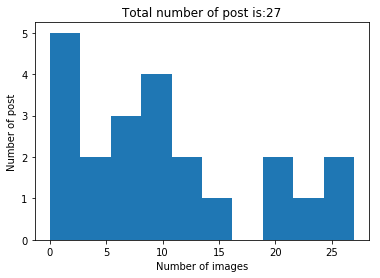

In [13]:
import matplotlib.pyplot as plt

plt.hist(lst)
title = "Total number of post is:" + str(len(posts))
plt.title(title)
plt.xlabel("Number of images")
plt.ylabel("Number of post")
plt.show()

We can found that most of the post are with less than 10 images<br>
We also can show the average like for different numbers of images in one post<br>
x axis means the number of pictures in one post, y means the average likes for post with certain numbers of images

In [9]:
from collections import OrderedDict
lst = []
pict_num = {}
for post in posts:
    if len(post) != 0:
        num_pict = len(post['img'])
        val = pict_num.get(num_pict, [0, 0])
        val[0] += 1
        val[1] += post['score']
        pict_num[num_pict] = val
        lst.append(num_pict)
sortdict = OrderedDict(sorted(pict_num.items()))
x_label = []
y_label = []
for key, val in sortdict.items():
    y_label.append(val[1] / val[0])
    x_label.append(key)

Text(0.5,1,'Average score for different number of images')

Text(0.5,0,'Number of image in one post')

Text(0,0.5,'Average score')

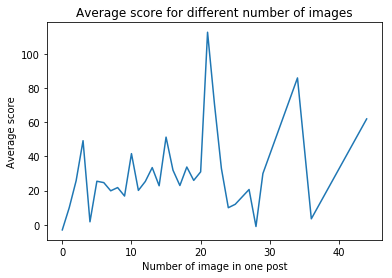

In [10]:
plt.title("Average score for different number of images")
plt.xlabel("Number of image in one post")
plt.ylabel("Average score")
plt.plot(x_label, y_label)
plt.show()

We didn't find specific rule from this graph, but can find that the post with 20 images has the highest average likes 
I think it's because the likes of each post depends on the level of beauty of images.

Since we have every comment of every post including the contnet of this comment, user id and like or not, so we could do the statistic to ovserve the trend of people who comment most. Therefore, we can find this person prefers "like" more than "unlike". In fact, users can also take "neutral" other than "like" or "dislike", we can use a constant to filter out people who comments less than this number

In [13]:
MOST_COMMENTS_USER = 100

In [14]:
# Total comments = total like + total dislike + total neutral
total_comments = {}
total_like = {}
total_dislike = {}
total_neutral = {} 

for post in posts:
    if len(post) != 0:
        for comment in post['comments']:
            total_comments[comment['user']] = total_comments.get(comment['user'], 0) + 1
            if comment['score'] == 0:
                total_neutral[comment['user']] = total_neutral.get(comment['user'], 0) + 1
            else:
                if comment['score'] == 1:
                    total_like[comment['user']] = total_like.get(comment['user'], 0) + 1
                elif comment['score'] == -1: 
                    total_dislike[comment['user']] = total_dislike.get(comment['user'], 0) + 1
                    

sorted_comments = sorted(total_comments.items(), key=lambda x:-x[1])[:MOST_COMMENTS_USER]

In [21]:
def show_comment_distr(total, like, dislike, neutral):
    y_total = [num[1] for num in total]
    names = [num[0] for num in total]
    y_like = [0] * MOST_COMMENTS_USER
    y_dislike = [0] * MOST_COMMENTS_USER
    y_neutral = [0] * MOST_COMMENTS_USER
    x = range(len(y_total))
    for idx in range(len(total)):
        if (total[idx][0] in like):
            y_like[idx] = like[total[idx][0]]
        if (total[idx][0] in dislike):
            y_dislike[idx] = dislike[total[idx][0]]
        if (total[idx][0] in neutral):
            y_neutral[idx] = neutral[total[idx][0]]
    f, ax = plt.subplots(figsize=(12, 8))
    ax.set(ylabel='counts',xlabel='',title='Total comments')
    ax.set_xticklabels(names, rotation= 45, fontsize = 12)
    plt.plot(x, y_total, label = 'Total comments', color='black')
    plt.plot(x, y_like, label = 'Total like', color='blue')
    plt.plot(x, y_dislike, label = 'Total dislike', color='red')
    plt.plot(x, y_neutral, label = 'Total neutral', color='green')
    ax.legend(ncol=2, loc='upper right', frameon=True)
    plt.show(f)

['kai6366', 'lovegogi', 'tpwin7', 'yoyonigo', 'OCG5566', 'mgochen', 'yuigood', 'belucky', 'andy199113', 'babyMclaren', 'so1518si', 'chenyenpo', 'pase139', 'NeGe56', 'PompelmousJ', 'gordon185', 'johnwu', 'Renting11', 'Geoffrey314', 'danny0108', 'socialhero', 'zxnstu3104', 'whitedull01', 'William0703', 'CY40', 'htc10', 'RG5678', 'morgen', 'adgbw8728', 'n61208', 'amare1015', 'cityhunter04', 'gen001', 'hatsuha', 'whatupjk', 'chen44', 'OGCer', 'inoce', 'coco100', 'yaehsin', 'Krishna', 'noname78531', 'chen0604z', 'hatephubbing', 'lsj049', 'qzwxecrv55', 'hat13201', 'sure0219', 'greyrose7', 'kathyfour', 'smalltalker', 'antiwow', 'EQUP', 'abellea85209', 'hamjji', 'telescopy', 'sheep0121', 'xetherz3', 'smonke', 'firemm666', 'kenslc199', 'DareJ', 'Refauth', 'Foreignline', 'yfguk6685', 'Boboinlyz', 'bh0925', 'lester36', 'trtc', 'W980', 'WASIJLA', 'nojydia', 'lck0', 'CHANYII', 'howard24', 'allen2134', 'Lisanity', 'lindada78', 'GGrunrundela', 'EEERRIICC', 'yitingted', 'joker00507', 'AlohaVC', 'micha

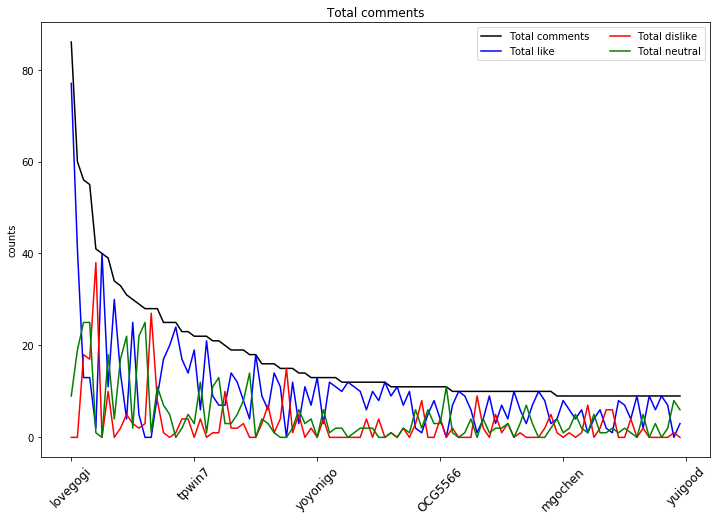

In [22]:
show_comment_distr(sorted_comments, total_like, total_dislike, total_neutral)

We can easily check the numbers of like ,dislike and neutral for the people who comments more.

Extract the image content
----------------------------
Sometimes we just want to review the image that most people like and don't care about the comment of users, we can just simply filter out the post with low scores, for example, we could extract the images of post with score over 30/40/50, so we will not review the images which may be not the "real" beauties.

In [8]:
threshold = 30
lst = []
for post in posts:
    if len(post) != 0:
        if (post['score'] >= threshold):
            dict = {}
            dict['score'] = post['score']
            dict['img'] = post['img']
            lst.append(dict)

In [10]:
for each in lst:
    print(each)

{'score': 115, 'img': ['http://www.facebook.com/PTTBeauty']}
{'score': 50, 'img': ['https://i.imgur.com/ZHjUSY4.jpg', 'https://i.imgur.com/iWEOn2J.jpg', 'https://i.imgur.com/1NeR81Y.jpg', 'https://i.imgur.com/vrOoFQl.jpg', 'https://i.imgur.com/Koabht5.jpg', 'https://i.imgur.com/FPmS55u.jpg', 'https://i.imgur.com/nsS5jhu.jpg', 'https://i.imgur.com/uIqIchT.jpg', 'https://i.imgur.com/Yfa43fW.jpg']}
{'score': 221, 'img': []}
{'score': 86, 'img': ['https://i.imgur.com/V95XOpF.jpg', 'https://i.imgur.com/XTs02c3.jpg', 'https://i.imgur.com/WmMdTPj.jpg', 'https://i.imgur.com/DSkJr0j.jpg', 'https://i.imgur.com/iV7wMPM.jpg', 'https://i.imgur.com/eJu3SQg.jpg', 'https://i.imgur.com/O6sj77t.jpg', 'https://i.imgur.com/tW1Yrhx.jpg', 'https://i.imgur.com/PJruz3w.jpg', 'https://i.imgur.com/ch8CCJA.jpg', 'https://i.imgur.com/T5rlMti.jpg', 'https://i.imgur.com/BJjHBj2.jpg']}
{'score': 330, 'img': ['#1NmIhY88']}
{'score': 77, 'img': ['https://imgur.com/PPrl3U9.jpg', 'https://imgur.com/dk1XUu3.jpg', 'https:

Now, we could also analyze the relationship between worlds in comment and the preference(like, dislike).
Since PTT is a forum from Taiwan, the comment must always be written in Chinese. Therefore, we must import python library which supports split chinese words from sentences. Then, we could use support vector machine to analyze the keywords within "like" and "dislike".<br>
For showing the Chinese on the grpah, please download the "SimHei" ttf font
```
https://github.com/StellarCN/scp_zh/blob/master/fonts/SimHei.ttf
```

In [23]:
# For identifying Chinese phrases
import jieba

In [24]:
comm_score = []
comm_words = []
for post in posts:
    if len(post) != 0:
        for comment in post['comments']:
            if comment['score'] != 0:
                sentence = comment['content'].strip()
                if sentence:
                    dict = {}
                    for word in jieba.cut(sentence):
                        dict[word] = dict.get(word, 0) + 1
                    if dict:
                        # If this comment is "like", set score to 1
                        comm_score.append(1 if comment['score'] > 0 else 0)
                        comm_words.append(dict)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/8t/pgh6s559145dvwjbd22j8qwm0000gn/T/jieba.cache
Loading model cost 0.792 seconds.
Prefix dict has been built succesfully.


In [28]:
# For creating sparse tfidf matrix 
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
import numpy as np

In [29]:
vec = DictVectorizer()
tfidf = TfidfTransformer()

# The second fit_transform is sparse matrix
X = tfidf.fit_transform(vec.fit_transform(comm_words))
arr = X.toarray()
svc = LinearSVC()
svc.fit(X, comm_score)
weights = svc.coef_[0]
# All the chinese vocabulary
feature_names = vec.get_feature_names()

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

For the following code, please remember to specify the write path of simhei.ttf to the FontProperties

In [37]:
from matplotlib.font_manager import * 
def comment_distr(comm_score, comm_words, top_n, positive):
    vec = DictVectorizer()
    tfidf = TfidfTransformer()
    
    # The second fit_transform is sparse matrix
    X = tfidf.fit_transform(vec.fit_transform(comm_words))
    arr = X.toarray()
    svc = LinearSVC()
    svc.fit(X, comm_score)
    weights = svc.coef_[0]
    feature_names = vec.get_feature_names()

    # Mine
    dict = {}
    for i in range(len(weights)):
        dict[weights[i]] = feature_names[i]
    od = OrderedDict(reversed(sorted(dict.items())))

    fig, ax = plt.subplots(figsize = (12, 8))
    ind = np.arange(top_n)

    if positive:
        top_weights = [key for key in od.keys()][:top_n]
        top_names = [val for val in od.values()][:top_n]
        # print(top_weights)
        # print(top_names)
        bars = ax.bar(ind, top_weights, color= 'blue', edgecolor= 'black')
    else:
        top_weights = [key for key in od.keys()][-top_n:]
        top_names = [val for val in od.values()][-top_n:]
        # print(top_weights)
        bars = ax.bar(ind, top_weights, color= 'red', edgecolor= 'black')

    width = 0.30
    ax.set_xticks(ind + width)
    # Please specify to the path you stored the simhei ttf
    myfont = FontProperties(fname='/Users/York/Downloads/simhei.ttf')  

    # Show Chinese vocabulary
    plt.rcParams['axes.unicode_minus']=False
    ax.set_xticklabels(top_names, rotation= 45, fontsize = 12, fontproperties=myfont)

    plt.show(fig)

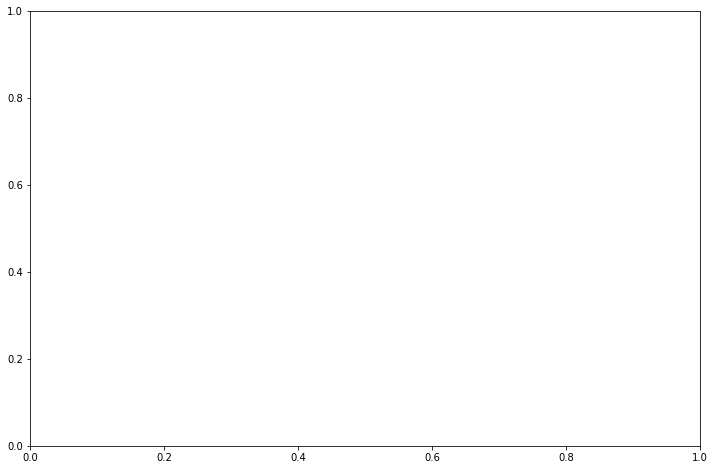

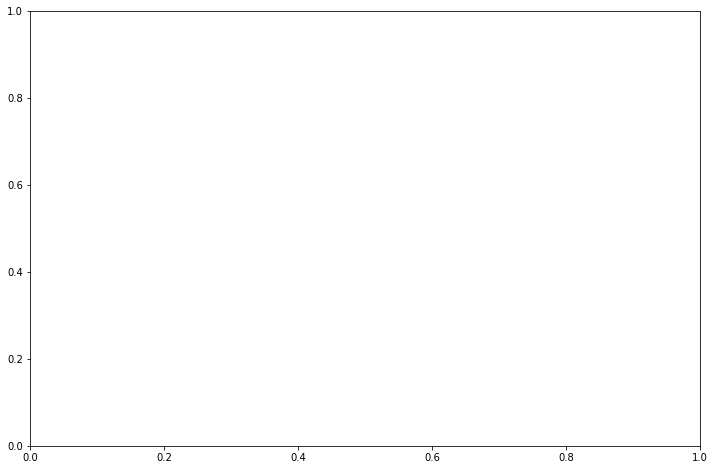

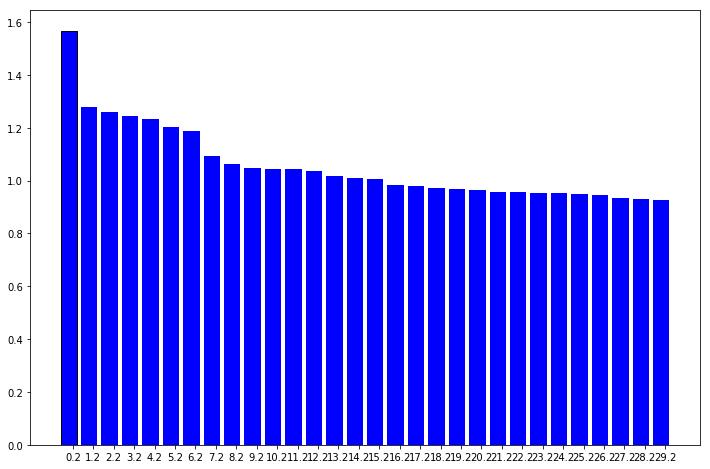

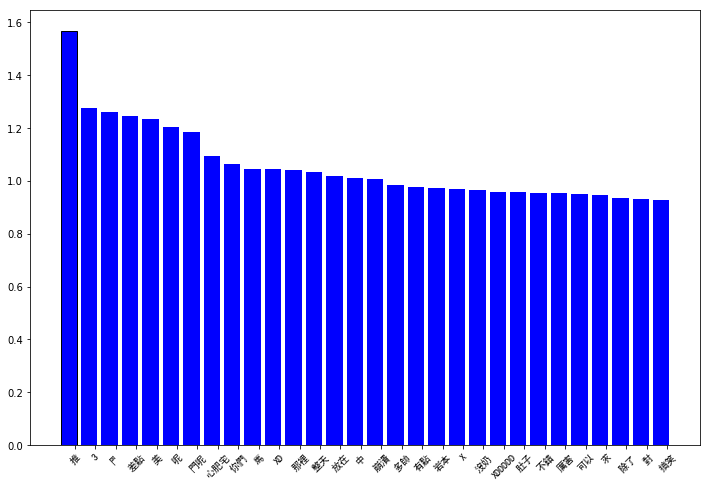

In [35]:
# Show the vocabulary of positive comment
comment_distr(comm_score, comm_words, 30, True)

For this part, I am also not quite clear why the plot is different from the one I showed on terminal, however, it could work normally at "dislike" situation(The following red bar graph)

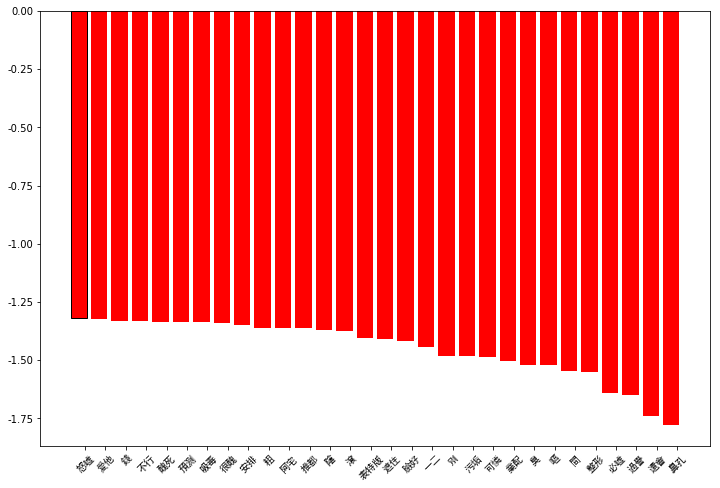

In [36]:
comment_distr(comm_score, comm_words, 30, False)

Blue bars means the vocabulary within "like" comment, and Red bars means the vocabulary within "dislike" comment, this analysis is collected the data from all of the posts, you can also set a threshold to filter the post with low score and analyze the comment for "like" and "dislike" again